# Importing Necessary Libraries

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import gc
import sys

### User Defined functions

In [2]:
# Function to calculate total and percentage of missing values
def missing_values_table(df):
    mis_val=df.isnull().sum()
    mis_val_percent=100*mis_val/len(df)
    mis_val_table=pd.concat([mis_val,mis_val_percent],axis=1)
    mis_val_table_ren_columns=mis_val_table.rename(columns={0:'Missing values',1:'% of Total_values'})
    mis_val_table_ren_columns=mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1]!=0].sort_values('% of Total_values',ascending=False).round(1)
    return mis_val_table_ren_columns


# Function to plot stats of variables
def plot_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();
    
# Function to plot distribution of variables
def plot_distribution(var):
    
    i = 0
    t1 = train.loc[application_train['TARGET'] != 0]
    t0 = train.loc[application_train['TARGET'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,2,figsize=(12,12))

    for feature in var:
        i += 1
        plt.subplot(2,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();
    
    
# Function to encode categorical data
def cnt_cat_vals(df,grp_clt_id,df_name):
    cat_vals=pd.get_dummies(df.select_dtypes('object'))
    cat_vals[grp_clt_id]=df[grp_clt_id]
    cat_vals=cat_vals.groupby(grp_clt_id).agg(['sum','mean'])
    clmn_hdgs=[]
    for i in cat_vals.columns.levels[0]:
        for j in ['Sum','Mean']:
            clmn_hdgs.append('%s %s %s'%(df_name,i,j))
    cat_vals.columns=clmn_hdgs
    return cat_vals


def agg_categorical(df, parent_var, df_name):
    categorical = pd.get_dummies(df.select_dtypes('category'))
    categorical[parent_var] = df[parent_var]
    categorical = categorical.groupby(parent_var).agg(['sum', 'count', 'mean'])
    column_names = []
    for var in categorical.columns.levels[0]:
        for stat in ['sum', 'count', 'mean']:
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    categorical.columns = column_names
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    return categorical


# Function to aggregate numerical columns
def agg_num(df,grp_clt_id,df_name):
    group_ids=df[grp_clt_id]
    num_df=df.select_dtypes('number')
    num_df[grp_clt_id]=group_ids
    agg_val=num_df.groupby(grp_clt_id).agg(['count','mean','max','min','sum']).reset_index()
    columns=[grp_clt_id]
    for i in agg_val.columns.levels[0]:
        if i!=grp_clt_id:
            for j in agg_val.columns.levels[1][:-1]:
                    columns.append('%s %s %s'% (df_name,i,j))
    agg_val.columns=columns
    return agg_val


def agg_numeric(df, parent_var, df_name):
    for col in df:
        if col != parent_var and 'SK_ID' in col:
            df = df.drop(columns = col)
    parent_ids = df[parent_var].copy()
    numeric_df = df.select_dtypes('number').copy()
    numeric_df[parent_var] = parent_ids
    agg = numeric_df.groupby(parent_var).agg(['count', 'mean', 'max', 'min', 'sum'])
    columns = []
    for var in agg.columns.levels[0]:
        if var != parent_var:
            for stat in agg.columns.levels[1]:
                columns.append('%s_%s_%s' % (df_name, var, stat)) 
    agg.columns = columns
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]
    return agg


def return_size(df):
    return round(sys.getsizeof(df) / 1e9, 2)

# Function to convert data
def convert_types(df, print_info = False):
    original_memory = df.memory_usage().sum()
    for c in df:
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
    new_memory = df.memory_usage().sum()
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df


# Function to merge files
def aggregate_client(df, group_vars, df_names):
    df_agg = agg_numeric(df, parent_var = group_vars[0], df_name = df_names[0])
    if any(df.dtypes == 'category'):
        df_counts = agg_categorical(df, parent_var = group_vars[0], df_name = df_names[0])
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')

        gc.enable()
        del df_agg, df_counts
        gc.collect()

        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])
    else:
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        
        gc.enable()
        del df_agg
        gc.collect()
        
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])
        
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client



### Application_Train data

In [3]:
train = pd.read_csv('application_train.csv')

In [4]:
# Training data
print('Training data shape: ', train.shape)
train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


1. This dataset consists of 307511 rows and 122 columns.
2. Each row has unique id ‘SK_ID_CURR’ and the output label is in the ‘TARGET’ column.
3. TARGET indicating 0: the loan was repaid or 1: the loan was not repaid.

In [5]:
train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [6]:
for col in train.columns: 
    print(col) 

SK_ID_CURR
TARGET
NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
CNT_CHILDREN
AMT_INCOME_TOTAL
AMT_CREDIT
AMT_ANNUITY
AMT_GOODS_PRICE
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
REGION_POPULATION_RELATIVE
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
OWN_CAR_AGE
FLAG_MOBIL
FLAG_EMP_PHONE
FLAG_WORK_PHONE
FLAG_CONT_MOBILE
FLAG_PHONE
FLAG_EMAIL
OCCUPATION_TYPE
CNT_FAM_MEMBERS
REGION_RATING_CLIENT
REGION_RATING_CLIENT_W_CITY
WEEKDAY_APPR_PROCESS_START
HOUR_APPR_PROCESS_START
REG_REGION_NOT_LIVE_REGION
REG_REGION_NOT_WORK_REGION
LIVE_REGION_NOT_WORK_REGION
REG_CITY_NOT_LIVE_CITY
REG_CITY_NOT_WORK_CITY
LIVE_CITY_NOT_WORK_CITY
ORGANIZATION_TYPE
EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
APARTMENTS_AVG
BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_AVG
COMMONAREA_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
FLOORSMIN_AVG
LANDAREA_AVG
LIVINGAPARTMENTS_AVG
LIVINGAREA_AVG
NONLIVINGAPARTMENTS_AVG
NONLIVINGAREA_AVG
APART

In [7]:
# Count No.of Repayers and Non- Repayers
train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

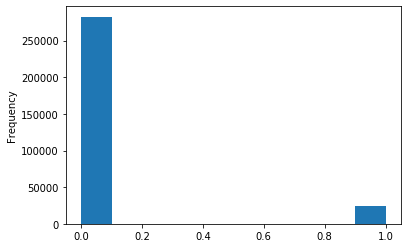

In [8]:
# Let's have look the TARGET on plot
train['TARGET'].astype(int).plot.hist();

The data is imbalanced about 90%(Loan repayed-0) and 10%(Loan not repayed-1) and we need to handle this problem

## Data cleaning and formatting

In [9]:
# Missing values statistics
missing_values = missing_values_table(train)
missing_values.head(20)

,Missing values,% of Total_values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


1. There are lot of missing values in each column.
2. We need to somehow handle these missing values, we will see how to handle further

In [10]:
columns_without_id = [col for col in train.columns if col!='SK_ID_CURR']
#Checking for duplicates in the data.
train[train.duplicated(subset = columns_without_id, keep=False)]
print('The no of duplicates in the data:',train[train.duplicated(subset = columns_without_id, keep=False)]
      .shape[0])

The no of duplicates in the data: 0


### Column Types


In [11]:
# Number of each type of column
train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

### Let's look for number of unique entries in each of the categorical features

In [12]:
# Number of unique classes in each categorical features
train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

#### For any categorical features (dtype == object) with 2 unique categories, we will use label encoding and for any categorical variable with more than 2 unique categories, we will use one-hot encoding

In [13]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in train:
    if train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(train[col].unique())) <= 2:
            # Train on the training data
            le.fit(train[col])
            # Transform both training and testing data
            train[col] = le.transform(train[col])
                       
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [14]:
# one-hot encoding of categorical variables
train = pd.get_dummies(train)

print('Training Features shape: ', train.shape)


Training Features shape:  (307511, 243)


## EDA

### Correlations

In [15]:
# Find correlations with the target and sort
correlations = train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DAYS_REGISTRATION                                    0.041975
OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

In [16]:
# Effect of Age on Repayment
train['DAYS_BIRTH'] = abs(train['DAYS_BIRTH'])
train['DAYS_BIRTH'].corr(train['TARGET'])

-0.07823930830982712

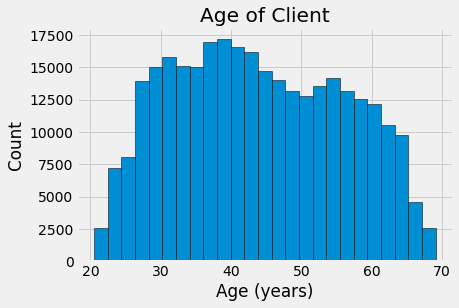

In [17]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

#### Effect of the age on the target
#### To visualize the effect of the age on the target, we make a kernel density estimation plot (KDE) colored by the value of the target

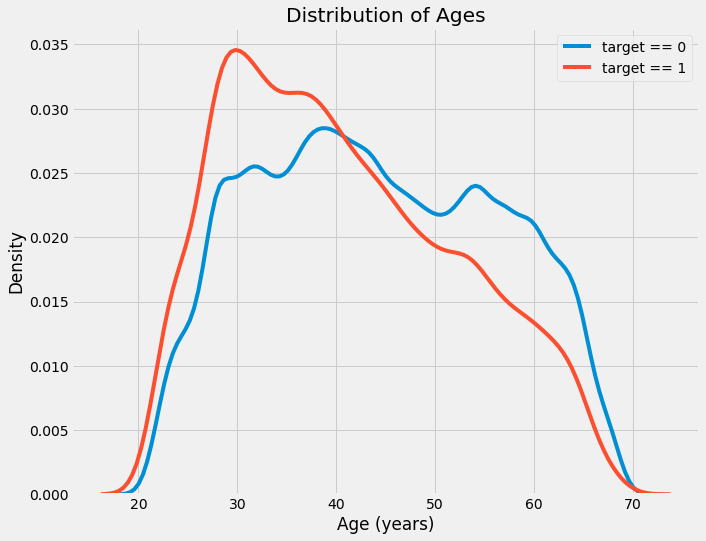

In [18]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

1. The target == 1 curve skews towards the younger end of the range.
2. To understand more, first we cut the age category into bins of 5 years each. Then, for each bin, we calculate the average value of the target, which tells us the ratio of loans that were not repaid in each age category.

In [19]:
# Age information into a separate dataframe
age_data = train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [20]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


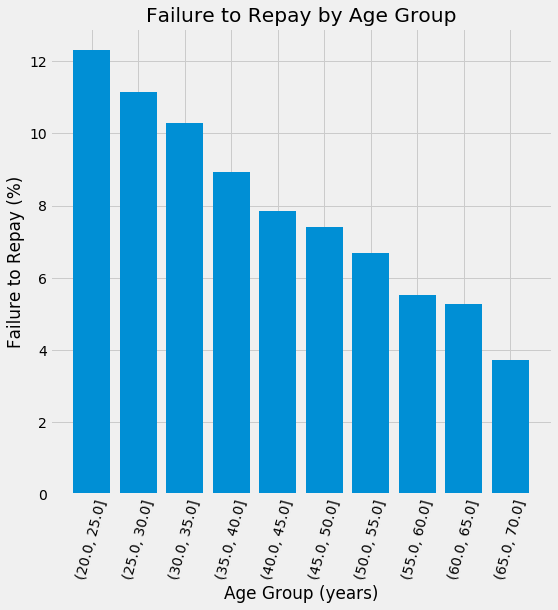

In [21]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

There is a clear trend: younger applicants are more likely to not repay the loan! The rate of failure to repay is above 10% for the youngest three age groups and beolow 5% for the oldest age group.

This is information that could be directly used by the bank: because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. This does not mean the bank should discriminate against younger clients, but it would be smart to take precautionary measures to help younger clients pay on time.

### Strongest Negative correlations
1. The 3 variables with the strongest negative correlations with the target are EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3.
2. First, let's visualize the correlations of the EXT_SOURCE features and target with each other

In [22]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


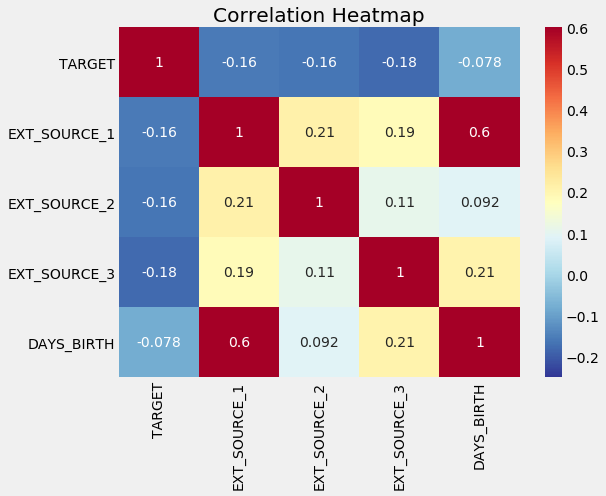

In [23]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

1. All three EXT_SOURCE features have negative correlations with the target, indicating that as the value of the EXT_SOURCE increases, the client is more likely to repay the loan. We can also see that DAYS_BIRTH is positively correlated with EXT_SOURCE_1 indicating that maybe one of the factors in this score is the client age.

2. Next we can look at the distribution of each of these features colored by the value of the target. This will let us visualize the effect of this variable on the target.

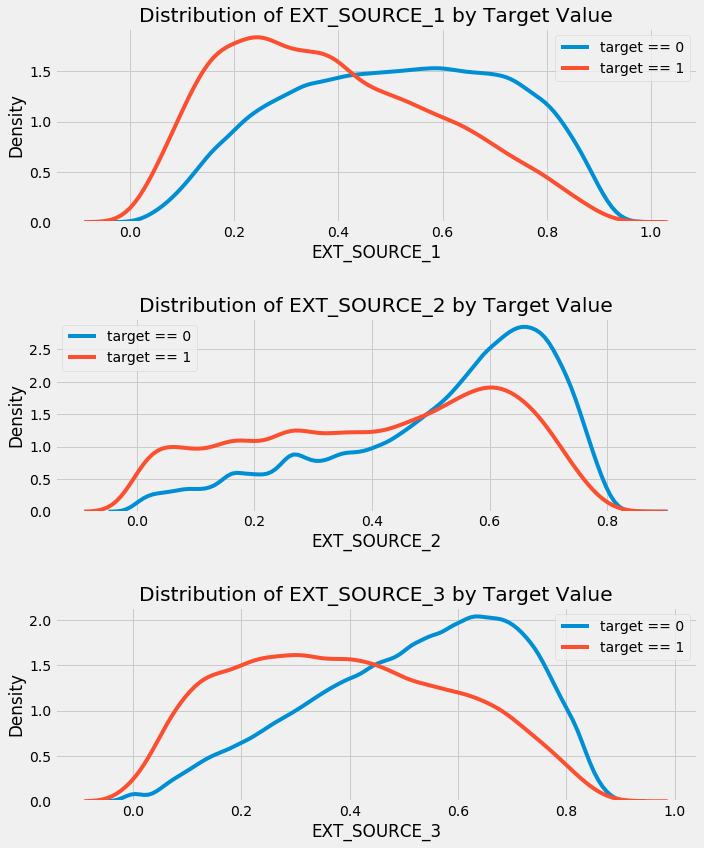

In [24]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(train.loc[train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(train.loc[train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
    

#### Distribution of AMT_INCOME_TOTAL

In [25]:
(train[train['AMT_INCOME_TOTAL'] > 1000000]['TARGET'].value_counts())/len(train[train['AMT_INCOME_TOTAL'] > 1000000])*100


0    94.8
1     5.2
Name: TARGET, dtype: float64

1. The distribution is right skewed and there are extreme values, we can apply log distribution.
2. People with high income(>1000000) are likely to repay the loan.

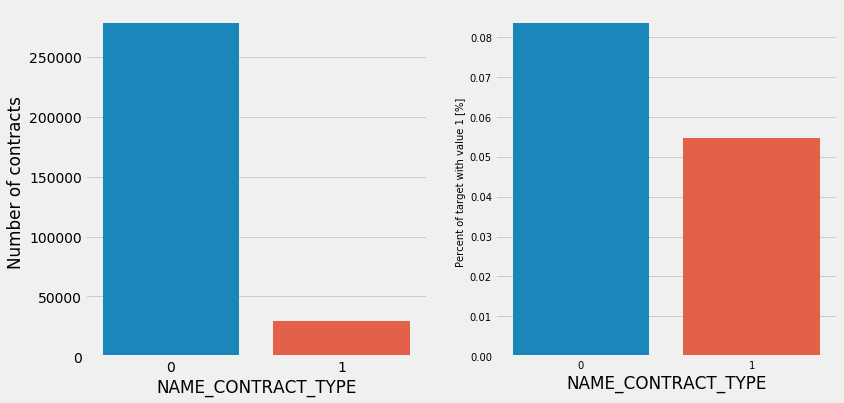

In [26]:
plot_stats('NAME_CONTRACT_TYPE')

we create polynomial features using the EXT_SOURCE variables and the DAYS_BIRTH variable

In [27]:
# Make a new dataframe for polynomial features
poly_features = train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]

# imputer for handling missing values

imputer = SimpleImputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)


from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [28]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)

print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


In [29]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

In [30]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


In [31]:
# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = train['SK_ID_CURR']
app_train_poly = train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)


Training data with polynomial features shape:  (307511, 279)


In [32]:
train_domain = train.copy()
train_domain['CREDIT_INCOME_PERCENT'] = train_domain['AMT_CREDIT'] / train_domain['AMT_INCOME_TOTAL']
train_domain['ANNUITY_INCOME_PERCENT'] = train_domain['AMT_ANNUITY'] / train_domain['AMT_INCOME_TOTAL']
train_domain['CREDIT_TERM'] = train_domain['AMT_ANNUITY'] / train_domain['AMT_CREDIT']
train_domain['DAYS_EMPLOYED_PERCENT'] = train_domain['DAYS_EMPLOYED'] / train_domain['DAYS_BIRTH']


#### Let's see these domain variables visually in a graph

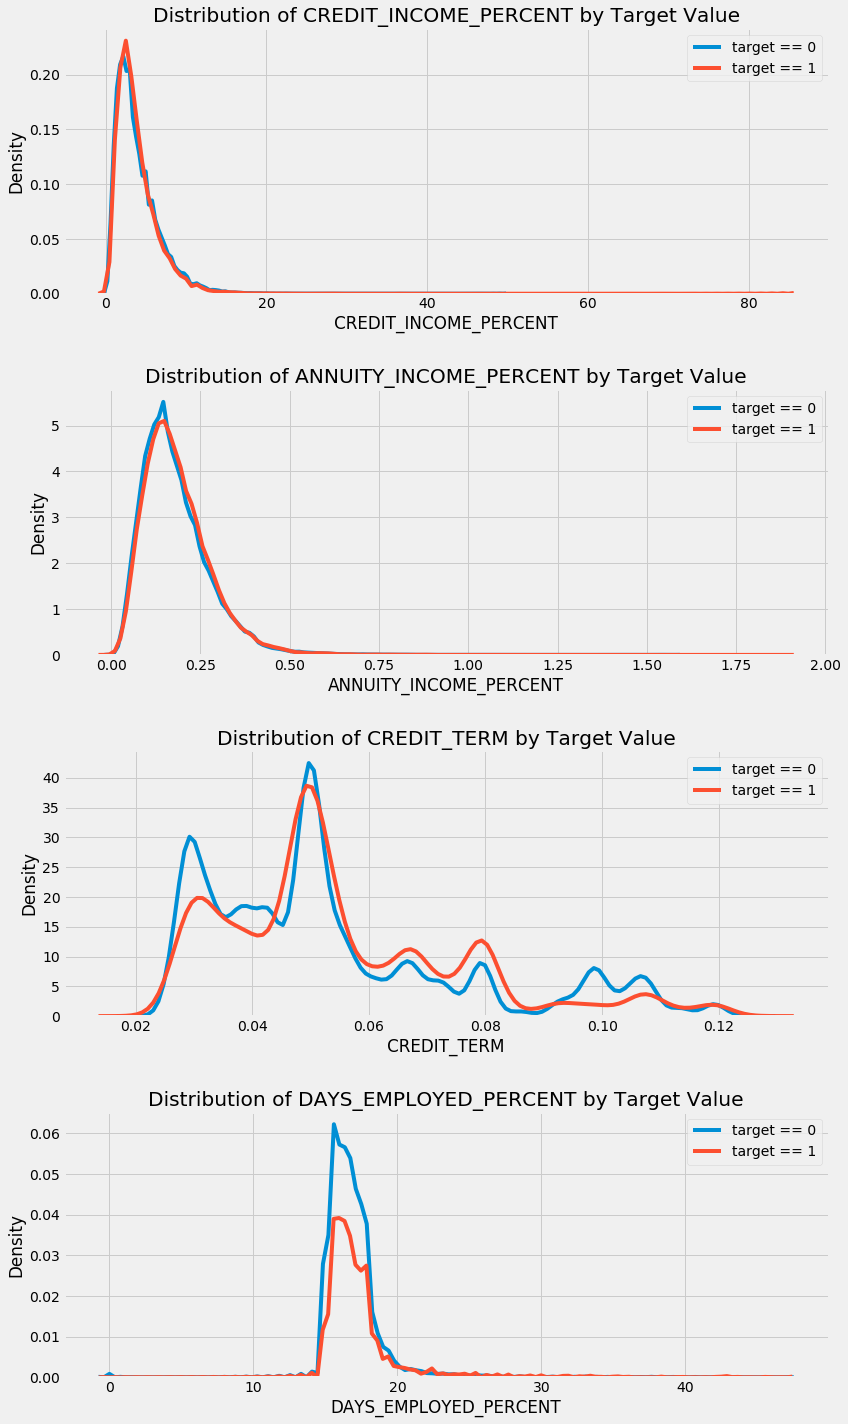

In [33]:
plt.figure(figsize = (12, 20))

# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(train_domain.loc[train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(train_domain.loc[train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

### Bureau data

In [34]:
bureau=pd.read_csv('bureau.csv')

In [35]:
print('Bureau data shape: ', bureau.shape)

Bureau data shape:  (1716428, 17)


In [36]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [37]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [38]:
# Categorical values in bureau
bureau_cnts=cnt_cat_vals(bureau,grp_clt_id='SK_ID_CURR',df_name='bureau')
bureau_cnts.head()

,bureau CREDIT_ACTIVE_Active Sum,bureau CREDIT_ACTIVE_Active Mean,bureau CREDIT_ACTIVE_Bad debt Sum,bureau CREDIT_ACTIVE_Bad debt Mean,bureau CREDIT_ACTIVE_Closed Sum,bureau CREDIT_ACTIVE_Closed Mean,bureau CREDIT_ACTIVE_Sold Sum,bureau CREDIT_ACTIVE_Sold Mean,bureau CREDIT_CURRENCY_currency 1 Sum,bureau CREDIT_CURRENCY_currency 1 Mean,...,bureau CREDIT_TYPE_Microloan Sum,bureau CREDIT_TYPE_Microloan Mean,bureau CREDIT_TYPE_Mobile operator loan Sum,bureau CREDIT_TYPE_Mobile operator loan Mean,bureau CREDIT_TYPE_Mortgage Sum,bureau CREDIT_TYPE_Mortgage Mean,bureau CREDIT_TYPE_Real estate loan Sum,bureau CREDIT_TYPE_Real estate loan Mean,bureau CREDIT_TYPE_Unknown type of loan Sum,bureau CREDIT_TYPE_Unknown type of loan Mean
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [39]:
# Numerical values in bureau
bureau_agg=agg_num(bureau.drop(columns=['SK_ID_BUREAU']),grp_clt_id='SK_ID_CURR',df_name='bureau')
bureau_agg.head()

,SK_ID_CURR,bureau DAYS_CREDIT count,bureau DAYS_CREDIT mean,bureau DAYS_CREDIT max,bureau DAYS_CREDIT min,bureau DAYS_CREDIT sum,bureau CREDIT_DAY_OVERDUE count,bureau CREDIT_DAY_OVERDUE mean,bureau CREDIT_DAY_OVERDUE max,bureau CREDIT_DAY_OVERDUE min,...,bureau DAYS_CREDIT_UPDATE count,bureau DAYS_CREDIT_UPDATE mean,bureau DAYS_CREDIT_UPDATE max,bureau DAYS_CREDIT_UPDATE min,bureau DAYS_CREDIT_UPDATE sum,bureau AMT_ANNUITY count,bureau AMT_ANNUITY mean,bureau AMT_ANNUITY max,bureau AMT_ANNUITY min,bureau AMT_ANNUITY sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [40]:
bureau_new=bureau_agg.merge(bureau_cnts,right_index=True,left_on='SK_ID_CURR',how='outer')

In [41]:
# Missing values in merged file
missing_bureau=missing_values_table(bureau_new)
missing_bureau

,Missing values,% of Total_values
bureau AMT_ANNUITY min,187587,61.3
bureau AMT_ANNUITY max,187587,61.3
bureau AMT_ANNUITY mean,187587,61.3
bureau AMT_CREDIT_MAX_OVERDUE mean,92840,30.4
bureau AMT_CREDIT_MAX_OVERDUE max,92840,30.4
bureau AMT_CREDIT_MAX_OVERDUE min,92840,30.4
bureau DAYS_ENDDATE_FACT mean,37656,12.3
bureau DAYS_ENDDATE_FACT max,37656,12.3
bureau DAYS_ENDDATE_FACT min,37656,12.3
bureau AMT_CREDIT_SUM_LIMIT mean,25308,8.3


In [42]:
# Imputing missing values with mean
imputer=SimpleImputer(strategy='mean')
imputer.fit(bureau_new)
bureau_new=imputer.transform(bureau_new)

In [43]:
#Converting to dataframe
bureau_new=pd.DataFrame(bureau_new)

### Bureau_balance data

In [44]:
bureau_balance=pd.read_csv('bureau_balance.csv')

In [45]:
print('Bureau_balance data shape: ', bureau_balance.shape)

Bureau_balance data shape:  (27299925, 3)


In [46]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [47]:
bureau_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [48]:
# Categorical values in bureau_balance
bureau_balance_cnts=cnt_cat_vals(bureau_balance,grp_clt_id='SK_ID_BUREAU',df_name='bureau_balance')
bureau_balance_cnts.head()

,bureau_balance STATUS_0 Sum,bureau_balance STATUS_0 Mean,bureau_balance STATUS_1 Sum,bureau_balance STATUS_1 Mean,bureau_balance STATUS_2 Sum,bureau_balance STATUS_2 Mean,bureau_balance STATUS_3 Sum,bureau_balance STATUS_3 Mean,bureau_balance STATUS_4 Sum,bureau_balance STATUS_4 Mean,bureau_balance STATUS_5 Sum,bureau_balance STATUS_5 Mean,bureau_balance STATUS_C Sum,bureau_balance STATUS_C Mean,bureau_balance STATUS_X Sum,bureau_balance STATUS_X Mean
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


In [49]:
# Numerical values in bureau_balance
bureau_balance_agg=agg_num(bureau_balance,grp_clt_id='SK_ID_BUREAU',df_name='bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance MONTHS_BALANCE count,bureau_balance MONTHS_BALANCE mean,bureau_balance MONTHS_BALANCE max,bureau_balance MONTHS_BALANCE min,bureau_balance MONTHS_BALANCE sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


In [50]:
#Merging categorical nad numerical data
bureau_balance_new=bureau_balance_agg.merge(bureau_balance_cnts,right_index=True,left_on='SK_ID_BUREAU',how='outer')

In [51]:
# Merging by loan
bureau_loan_cnt = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_balance_new, on = 'SK_ID_BUREAU', how = 'left')

In [52]:
# Numerical values of loan data
bureau_balance_client = agg_num(bureau_loan_cnt.drop(columns = ['SK_ID_BUREAU']), grp_clt_id = 'SK_ID_CURR', df_name = 'client')

In [53]:
missing_bureau_balance=missing_values_table(bureau_balance)
missing_bureau_balance

,Missing values,% of Total_values


### Previous_application data

In [54]:
previous = pd.read_csv('previous_application.csv')

In [55]:
# Converting data,Categorical and numerical values in previous_application
previous = convert_types(previous, print_info=True)
prev_agg = agg_numeric(previous, 'SK_ID_CURR', 'previous')
previous_counts = agg_categorical(previous, 'SK_ID_CURR', 'previous')

Original Memory Usage: 0.49 gb.
New Memory Usage: 0.18 gb.


In [56]:
# Converting to dataframe
previous_counts=pd.DataFrame(previous_counts)
prev_agg=pd.DataFrame(prev_agg)

### Credit_card_balance data

In [57]:
credit = pd.read_csv('credit_card_balance.csv')

In [58]:
print('Credit_card data shape: ', credit.shape)

Credit_card data shape:  (3840312, 23)


In [59]:
credit.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [60]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

In [61]:
# Converting data and aggregating numerical data
credit = convert_types(credit, print_info = True)
credit_by_client = aggregate_client(credit, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['credit', 'client'])

Original Memory Usage: 0.71 gb.
New Memory Usage: 0.42 gb.


In [62]:
#Converting to dataframe
credit=pd.DataFrame(credit_by_client)

### pos_cash_balance data

In [63]:
cash = pd.read_csv('pos_cash_balance.csv')

In [64]:
print('pos_cash data shape: ', cash.shape)

pos_cash data shape:  (10001358, 8)


In [65]:
cash.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [66]:
cash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [67]:
# Converting data and aggregating numerical data
cash = convert_types(cash, print_info=True)
cash_by_client = aggregate_client(cash, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])

Original Memory Usage: 0.64 gb.
New Memory Usage: 0.41 gb.


In [68]:
#Converting to dataframe
cash=pd.DataFrame(cash_by_client)

### Installment_payments data

In [69]:
installments = pd.read_csv('installments_payments.csv')

In [70]:
print('installments data shape: ', installments.shape)

installments data shape:  (13605401, 8)


In [71]:
installments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [72]:
installments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


In [73]:
installments

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585
...,...,...,...,...,...,...,...,...
13605396,2186857,428057,0.0,66,-1624.0,NaN,67.500,NaN
13605397,1310347,414406,0.0,47,-1539.0,NaN,67.500,NaN
13605398,1308766,402199,0.0,43,-7.0,NaN,43737.435,NaN
13605399,1062206,409297,0.0,43,-1986.0,NaN,67.500,NaN


In [74]:
# Converting data and aggregating numerical data
installments = convert_types(installments, print_info = True)
installments_by_client = aggregate_client(installments, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['installments', 'client'])

Original Memory Usage: 0.87 gb.
New Memory Usage: 0.49 gb.


In [75]:
#Converting to dataframe
installments=pd.DataFrame(installments_by_client)

In [76]:
# Merging train and bureau categorical data
train_bureau_cnts = train.merge(bureau_cnts, on = 'SK_ID_CURR', how = 'left')

In [77]:
# Merging train_bureau categorical and bureau numerical data
train_bureau_agg = train_bureau_cnts.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

In [78]:
# Merging train_bureau categorical and numerical and bureau_balance by client data
train_bureau_balance_client = train_bureau_agg.merge(bureau_balance_client, on = 'SK_ID_CURR', how = 'left')

In [79]:
# Merging train_bureau_balance data with previous data
train_bureau_previous = train_bureau_balance_client.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
train_bureau_previous = train_bureau_balance_client.merge(prev_agg, on = 'SK_ID_CURR', how = 'left')

In [80]:
# Merging train_bureau_previous data with cash data
train_bureau_previous_cash = train_bureau_previous.merge(cash, on = 'SK_ID_CURR', how = 'left')

In [81]:
# Merging train_bureau_previous_cash data with credit data
train_bureau_previous_cash_credit = train_bureau_previous_cash.merge(credit, on = 'SK_ID_CURR', how = 'left')

In [82]:
# Merging train_bureau_previous_cash_credit data with installments data
train_final = train_bureau_previous_cash_credit.merge(installments, on = 'SK_ID_CURR', how = 'left')

In [83]:
train_final.to_csv('train_final.csv')

In [84]:
train_final

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
0,100002,1,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,1.757837e+05,1.757837e+05,2.196257e+05,2.196257e+05,2.196257e+05,2.196257e+05,1.008781e+06,1.008781e+06,4.172888e+06,4.172888e+06
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,1.154108e+06,1.154108e+06,1.150977e+06,1.150977e+06,1.618865e+06,1.618865e+06,4.394102e+06,4.394102e+06,1.134881e+07,1.134881e+07
2,100004,0,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,1.607175e+04,1.607175e+04,2.128846e+04,2.128846e+04,2.128846e+04,2.128846e+04,3.172189e+04,3.172189e+04,6.386539e+04,6.386539e+04
3,100006,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,9.944767e+05,9.944767e+05,6.917869e+05,6.917869e+05,1.007153e+06,1.007153e+06,1.057860e+06,1.057860e+06,3.719995e+06,3.719995e+06
4,100007,0,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,4.837564e+05,8.258458e+05,2.801997e+05,2.946311e+05,8.061279e+05,8.359853e+05,8.367034e+05,8.367034e+05,1.139621e+07,1.179154e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,0,0,0,157500.0,254700.0,27558.0,225000.0,...,4.624137e+04,4.624137e+04,5.245047e+04,5.245047e+04,5.245047e+04,5.245047e+04,8.970507e+04,8.970507e+04,3.671533e+05,3.671533e+05
307507,456252,0,0,0,1,0,72000.0,269550.0,12001.5,225000.0,...,6.028128e+04,6.028128e+04,6.041920e+04,6.041920e+04,6.041920e+04,6.041920e+04,6.044679e+04,6.044679e+04,3.625152e+05,3.625152e+05
307508,456253,0,0,0,1,0,153000.0,677664.0,29979.0,585000.0,...,4.180599e+04,6.152904e+04,3.341376e+04,3.341376e+04,5.762281e+04,6.159591e+04,6.166175e+04,6.166175e+04,3.048920e+05,3.247575e+05
307509,456254,1,0,0,1,0,171000.0,370107.0,20205.0,319500.0,...,1.945568e+05,1.945568e+05,1.715924e+05,1.715924e+05,1.945568e+05,1.945568e+05,1.945568e+05,1.945568e+05,1.773976e+06,1.773976e+06
